# Decide the model type

In [72]:
import os
import pandas as pd
import numpy as np
from scipy.optimize import brentq
import matplotlib.pyplot as plt

# load data

In [74]:
os.chdir(os.path.expanduser('~/Desktop/2025Spring/Math548/final project'))
print("Working directory:", os.getcwd())
print("Contains:", os.listdir())

Working directory: C:\Users\OY\Desktop\2025Spring\Math548\final project
Contains: ['48_k=0.2_modified.csv', 'data', 'Desktop', 'Final.docx', 'full_data.xlsx', 'high_frequency(1).xlsx', 'high_frequency.csv', 'jan_02.csv', 'list all the definition of variables and parameter.pdf', 'Madan et al. (2019).pdf', 'MLQF S25 Exam Guide.pdf', 'Proposition 2.py', 'time_series.csv', 'updata_full data.xlsx', 'update.csv', 'update_TS.csv', '~$Final.docx']


In [75]:
df = pd.read_csv('high_frequency.csv', parse_dates=['Time'])
df.sort_values('Time', inplace=True)

In [76]:
#high frequency VIX data in Jan 02
X = df['VIX'].values

# Activity index β calculation

In [106]:
def compute_activity_index(X, L=0.5, Δ=1, verbose=True):
    dX = np.diff(X)
    dX1 = dX[::Δ]                   # 1-min increments
    dX2 = X[2*Δ::2*Δ] - X[:-2*Δ:2*Δ] # 2Δ-min increments
    trunc_ratio = np.mean(np.abs(dX1) > L)
    
    if verbose:
        print("\n===== Truncation Analysis (l=0.5) =====")
        print(f"Absolute 1-min increment statistics:")
        print(f"• Median: {np.median(np.abs(dX1)):.4f}")
        print(f"• 95th percentile: {np.quantile(np.abs(dX1), 0.95):.4f}")
        print(f"• Maximum: {np.max(np.abs(dX1)):.4f}")
        print(f"\nTruncated {trunc_ratio:.2%} increments (|ΔX| > {L})")
    
    def V(p, dX):
        if p < 2:
            mask = np.abs(dX) <= L
            return np.sum(np.abs(dX)**p * mask)
        return np.sum(np.abs(dX)**p)
    
    def b_of_p(p):
        V1 = V(p, dX1)
        V2 = V(p, dX2)
        return (np.log(2)*p) / (np.log(2) + np.log(V2) - np.log(V1))
    
    p_grid = np.linspace(0.05, 1.95, 191)
    f_vals = [b_of_p(p) - p for p in p_grid]
    
    brackets = [(p_grid[i], p_grid[i+1]) 
               for i in range(len(p_grid)-1) 
               if f_vals[i]*f_vals[i+1] < 0]
    
    if brackets:
        beta_hat = brentq(lambda p: b_of_p(p) - p, brackets[0][0], brackets[0][1])
        method = "Root-finding"
    else:
        beta_hat = p_grid[np.argmin(np.abs(f_vals))]
        method = "Fallback (min |b(p)-p|)"
    
    if verbose:
        print("\n===== Activity Index Result =====")
        print(f"Estimated β: {beta_hat:.3f} | Method: {method}")
        print("\nSensitivity to L (for β≈1.7-1.8 target):")
        for L_test in [0.2,0.3,0.4,0.5]:
            ratio = np.mean(np.abs(dX1) > L_test)
            print(f"• L={L_test:.1f} → trunc={ratio:.1%}")
        print("\nL represents the Truncation threshold (filters extreme jumps)")
        print("\nΔ represents Base sampling interval")
    return beta_hat, method, trunc_ratio

In [108]:
beta_hat, method, trunc_ratio = compute_activity_index(X, L=0.5)


===== Truncation Analysis (l=0.5) =====
Absolute 1-min increment statistics:
• Median: 0.0200
• 95th percentile: 0.1400
• Maximum: 0.3200

Truncated 0.00% increments (|ΔX| > 0.5)

===== Activity Index Result =====
Estimated β: 1.715 | Method: Root-finding

Sensitivity to L (for β≈1.7-1.8 target):
• L=0.2 → trunc=1.7%
• L=0.3 → trunc=0.3%
• L=0.4 → trunc=0.0%
• L=0.5 → trunc=0.0%

L represents the Truncation threshold (filters extreme jumps)

Δ represents Base sampling interval


# Data for calibration model

In [81]:
cols = ['Strike', 'IVM_call', 'Volm_call', 'TTM_year',
        'mid_price_call', 'IVM_Put', 'Volm_Put', 'mid_price_put','spot_price','Bid','Ask',
        'Bid_Put','Ask_Put']
df_Jan02 = pd.read_csv('jan_02.csv')[cols]
# display a quick summary
df_Jan02.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Strike          96 non-null     float64
 1   IVM_call        96 non-null     float64
 2   Volm_call       96 non-null     int64  
 3   TTM_year        96 non-null     float64
 4   mid_price_call  96 non-null     float64
 5   IVM_Put         96 non-null     float64
 6   Volm_Put        96 non-null     int64  
 7   mid_price_put   96 non-null     float64
 8   spot_price      96 non-null     float64
 9   Bid             96 non-null     float64
 10  Ask             96 non-null     float64
 11  Bid_Put         96 non-null     float64
 12  Ask_Put         96 non-null     float64
dtypes: float64(11), int64(2)
memory usage: 9.9 KB


In [82]:
ranges_cali = df_Jan02.agg({
    'TTM_year': ['min','max'],
    'Strike'  : ['min','max'],
    'spot_price' :['min','max'],
   'mid_price_put' :['min','max']
})
print("\nRanges:")
print(ranges_cali)


Ranges:
     TTM_year  Strike  spot_price  mid_price_put
min  0.054795    0.09      0.1793         0.0001
max  0.706849    0.28      0.1793         0.1090


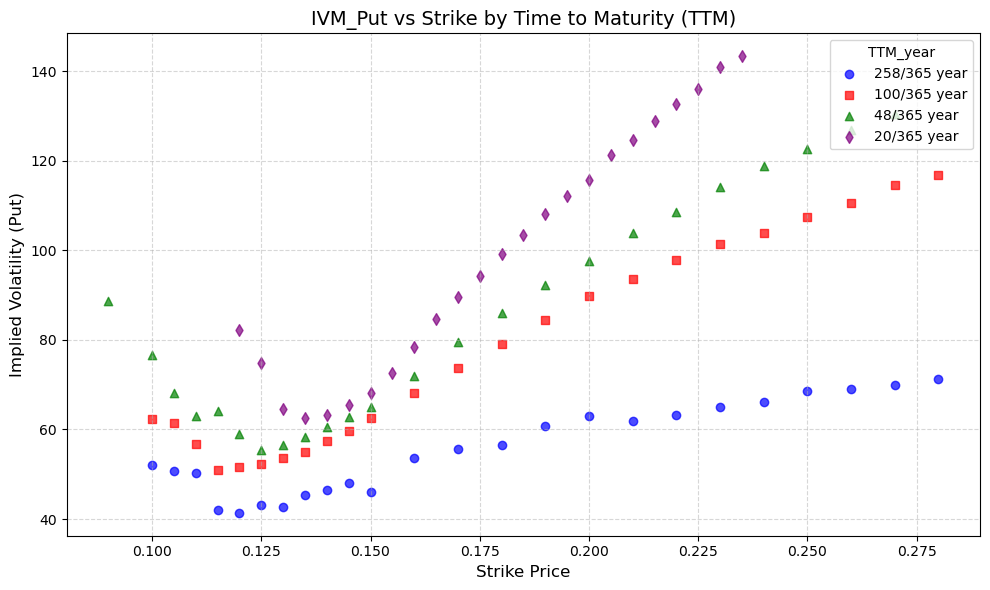

In [83]:
#plot of IVM_Put change over different strike
ttm_groups = {
    0.706849315: {'color': 'blue', 'label': '258/365 year', 'marker': 'o'},
    0.273972603: {'color': 'red', 'label': '100/365 year', 'marker': 's'},
    0.131506849: {'color': 'green', 'label': '48/365 year', 'marker': '^'},
    0.054794521: {'color': 'purple', 'label': '20/365 year', 'marker': 'd'}
}

plt.figure(figsize=(10, 6))

for ttm, style in ttm_groups.items():
    mask = df_Jan02['TTM_year'] == ttm
    plt.scatter(
        df_Jan02.loc[mask, 'Strike'],
        df_Jan02.loc[mask, 'IVM_Put'],
        c=style['color'],
        marker=style['marker'],
        label=style['label'],
        alpha=0.7
    )


plt.xlabel('Strike Price', fontsize=12)
plt.ylabel('Implied Volatility (Put)', fontsize=12)
plt.title('IVM_Put vs Strike by Time to Maturity (TTM)', fontsize=14)
plt.legend(loc='upper right', title='TTM_year')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# arbitrage test for calibration data

In [85]:
df = pd.read_csv('jan_02.csv').reset_index(drop=True)
tol = 1e-6

df = df.sort_values('Strike').reset_index(drop=True)

df['K_rel'] = df['Strike'] / df['spot_price']
is_short = df['TTM_year'] <= 0.054794521
mask_short = is_short & df['K_rel'].between(0.85, 1.25)
mask_long  = ~is_short & df['K_rel'].between(1.00, 5.00)

df_valid = df.loc[mask_short | mask_long].reset_index(drop=True)
print(f">>> {len(df_valid)} strikes in the “reasonable” range (out of {len(df)})")


>>> 46 strikes in the “reasonable” range (out of 96)


# put–call parity test

In [87]:
# Two‐price put–call parity test
for col in ['Bid','Ask','Bid_Put','Ask_Put']:
    df[col] = df[col] / 100.0

# compute S0−K and the two bounds
df['S_minus_K']   = df['spot_price'] - df['Strike']
df['lower_bound'] = df['Bid']  - df['Ask_Put']
df['upper_bound'] = df['Ask']  - df['Bid_Put']

#find violations
low_idx  = df.index[df['lower_bound'] > df['S_minus_K']]
high_idx = df.index[df['upper_bound'] < df['S_minus_K']]
all_idx  = low_idx.union(high_idx)

print(f">>> Lower-bound violations (bidC–askP ≤ S−K):    {len(low_idx)}")
print(f">>> Upper-bound violations (S−K ≤ askC–bidP):    {len(high_idx)}")
print(f">>> Total parity violations:                     {len(all_idx)}")

# show the bad rows
display(
    df.loc[all_idx,
           ['Strike','TTM_year',
            'Bid','Ask','Bid_Put','Ask_Put',
            'lower_bound','S_minus_K','upper_bound']]
)

>>> Lower-bound violations (bidC–askP ≤ S−K):    72
>>> Upper-bound violations (S−K ≤ askC–bidP):    24
>>> Total parity violations:                     96


,Strike,TTM_year,Bid,Ask,Bid_Put,Ask_Put,lower_bound,S_minus_K,upper_bound
0,0.090,0.131507,0.0905,0.0930,0.0000,0.0002,0.0903,0.0893,0.0930
1,0.100,0.706849,0.0820,0.1010,0.0000,0.0017,0.0803,0.0793,0.1010
2,0.100,0.131507,0.0805,0.0835,0.0000,0.0002,0.0803,0.0793,0.0835
3,0.100,0.273973,0.0825,0.0850,0.0000,0.0002,0.0823,0.0793,0.0850
4,0.105,0.706849,0.0775,0.0970,0.0000,0.0020,0.0755,0.0743,0.0970
...,...,...,...,...,...,...,...,...,...
91,0.270,0.273973,0.0147,0.0152,0.0995,0.1005,-0.0858,-0.0907,-0.0843
92,0.270,0.706849,0.0194,0.0277,0.0910,0.1030,-0.0836,-0.0907,-0.0633
93,0.270,0.131507,0.0116,0.0120,0.0985,0.0995,-0.0879,-0.0907,-0.0865
94,0.280,0.706849,0.0184,0.0264,0.0995,0.1120,-0.0936,-0.1007,-0.0731


# Monotonicity test for puts

In [89]:
df = df.sort_values('Strike').reset_index(drop=True)
df['put_diff'] = df['mid_price_put'].diff().fillna(0)
mono_viol_idx = df.index[df['put_diff'] < 0]
print(f">>> Monotonicity violations: {len(mono_viol_idx)}")
df.drop(index=mono_viol_idx, inplace=True)

>>> Monotonicity violations: 38


# convexity test for puts

In [91]:
df = df.sort_values('Strike').reset_index(drop=True)
conv_viol_idx = []
for i in range(1, len(df)-1):
    K0, K1, K2 = df.loc[i-1,'Strike'], df.loc[i,'Strike'], df.loc[i+1,'Strike']
    P0, P1, P2 = df.loc[i-1,'mid_price_put'], df.loc[i,'mid_price_put'], df.loc[i+1,'mid_price_put']
    w0 = (K2 - K1)/(K2 - K0)
    w2 = (K1 - K0)/(K2 - K0)
    if P1 > (w0*P0 + w2*P2) + tol:
        conv_viol_idx.append(i)
print(f">>> Convexity violations: {len(conv_viol_idx)}")
df.drop(index=conv_viol_idx, inplace=True)

>>> Convexity violations: 23


C:\Users\OY\AppData\Local\Temp\ipykernel_16996\4096135617.py:6: RuntimeWarning: invalid value encountered in scalar divide
  w0 = (K2 - K1)/(K2 - K0)
C:\Users\OY\AppData\Local\Temp\ipykernel_16996\4096135617.py:7: RuntimeWarning: invalid value encountered in scalar divide
  w2 = (K1 - K0)/(K2 - K0)


In [92]:
df = df.drop(columns=['K_rel','put_diff']).reset_index(drop=True)
df.to_csv('jan_02_clean.csv', index=False)

# Data for time series robustness checking

In [94]:
df_full = (
    pd.read_csv('48_k=0.2_modified.csv')
      
)


df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Strike         31 non-null     float64
 1   Ticker         31 non-null     object 
 2   TTM_year       31 non-null     float64
 3   TTM_day        31 non-null     int64  
 4   Bid_Put        31 non-null     float64
 5   Ask_Put        31 non-null     float64
 6   IVM_Put        31 non-null     float64
 7   Volm_Put       31 non-null     int64  
 8   mid_price_Put  31 non-null     float64
 9   spot_price     31 non-null     float64
dtypes: float64(7), int64(2), object(1)
memory usage: 2.6+ KB


In [96]:
ranges = df_full.agg({
    'TTM_year': ['min','max'],
    'Strike'  : ['min','max'],
    'spot_price' :['min','max'],
    'mid_price_Put' :['min','max']
})
print("\nRanges:")
print(ranges)


Ranges:
     TTM_year  Strike  spot_price  mid_price_Put
min  0.002740     0.2      0.1477        0.03005
max  0.131507     0.2      0.1954        0.04475
